In [227]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [228]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [230]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [231]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [232]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [233]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [234]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [235]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [237]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [238]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [239]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

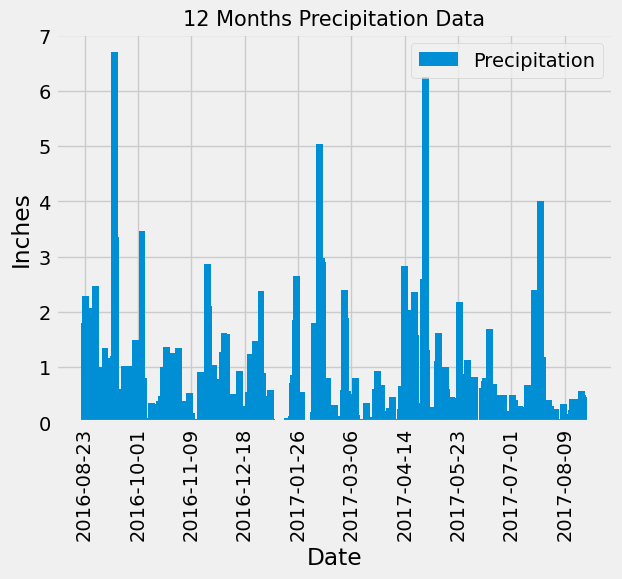

In [240]:
# Starting from the most recent data point in the database. 
end_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
start_date = end_date - relativedelta(months=12) 


df = pd.DataFrame([{"Date": x[0], "Precipitation": x[1]} for x in session.\
                                query(Measurement.date, Measurement.prcp).\
                                filter(Measurement.date >= start_date).\
                                order_by(Measurement.date).\
                                all() ])

df["Date"] = pd.to_datetime(df["Date"])
xticks = pd.DataFrame(df['Date'].unique(), columns=['Date'])

plt.bar(df['Date'], df["Precipitation"], width=5, label='Precipitation')

N = 39 
plt.xticks(xticks['Date'][::N], xticks['Date'][::N].dt.strftime('%Y-%m-%d'), rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title('12 Months Precipitation Data', fontsize=15)
plt.legend()
plt.show()

In [244]:
df['Precipitation'].describe().to_frame()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [247]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [249]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).distinct().count()

9

In [251]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
[x for x in session.
     query(Measurement.station, 
        func.count(Measurement.station))
        .group_by(Measurement.station)
        .order_by(desc(func.count(Measurement.station)))]

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [253]:
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs), 
              func.avg(Measurement.tobs)).\
                filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

In [255]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

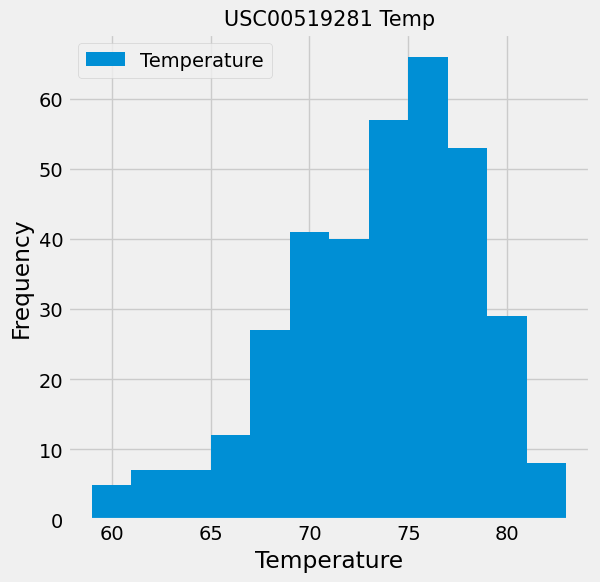

In [257]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

args = [Measurement.date, Measurement.tobs]
station_temp =session.query(*args).filter(Measurement.station == "USC00519281",
                            Measurement.date >= start_date).\
                            all()
pd.DataFrame(station_temp, columns=['date', 'Temperature']).plot(kind='hist',figsize=(6,6), bins=12)
plt.title('USC00519281 Temp', fontsize=15)
plt.xlabel('Temperature')
plt.show()

# Close Session

In [260]:
# Close Session
session.close()